# Slime Mould GEOjson Based Simulation
## Mohamed Berrada

# Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import networkx as nx
import math
from empiricaldist import Pmf
import random
from collections import deque
from matplotlib.animation import FuncAnimation, PillowWriter
import pandas as pd
from shapely.geometry import Point, Polygon
import json
import os

if not os.path.exists(os.path.join(os.getcwd(), 'output')):
    os.makedirs(os.path.join(os.getcwd(), 'output'))

## Util Functions

In [2]:
def degrees(G):
    """List of degrees for nodes in `G`.

    G: Graph object

    returns: list of int
    """
    return [G.degree(u) for u in G]

def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

def node_clustering(G, u):
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan

    edges = [G.has_edge(v, w) for v, w in all_pairs(neighbors)]
    return np.mean(edges)


def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cu = [node_clustering(G, node) for node in G]
    return np.nanmean(cu)

def path_lengths(G):
    length_iter = nx.shortest_path_length(G)
    for source, dist_map in length_iter:
        for dest, dist in dist_map.items():
            if source != dest:
                yield dist


def characteristic_path_length(G):
    return np.mean(list(path_lengths(G)))

def savefig(filename, **options):
    """Save the current figure.

    Keyword arguments are passed along to plt.savefig

    https://matplotlib.org/api/_as_gen/matplotlib.pyplot.savefig.html

    filename: string
    """
    print("Saving figure to file", filename)
    plt.savefig(filename, **options)

def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.

    d: dictionary
    options: keyword args to add to d
    """
    for key, val in options.items():
        d.setdefault(key, val)

    return d

def legend(**options):
    """Draws a legend only if there is at least one labeled item.

    options are passed to plt.legend()
    https://matplotlib.org/api/_as_gen/matplotlib.pyplot.legend.html

    """
    underride(options, loc="best", frameon=False)

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, **options)

def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like

    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties

    https://matplotlib.org/api/axes_api.html

    In addition, you can use `legend=False` to suppress the legend.

    And you can use `loc` to indicate the location of the legend
    (the default value is 'best')
    """
    loc = options.pop("loc", "best")
    if options.pop("legend", True):
        legend(loc=loc)

    plt.gca().set(**options)
    plt.tight_layout()

## Slime Mould

### Cell

In [3]:
class Cell:
    def __init__(self, pheromone=0., cell_type=0):
        self.pheromone = pheromone
        self.cell_type = cell_type

    def get_cell_type(self):
        return self.cell_type


### Food

In [4]:
class FoodCell(Cell):
    def __init__(self, food_id: int, food_idx: tuple):
        super().__init__(pheromone=10., cell_type=2)
        self.food_id = food_id
        self.food_idx = food_idx
        self.pheromone = 10.

    def get_food_idx(self):
        return self.food_idx

    def get_food_id(self):
        return self.food_id


### Slime

In [5]:
DIFFUSION_THRESHOLD = 3.5
DIFFUSION_DECAY_RATE = 1.26
DISTANCE_FOR_DIFFUSION_THRESHOLD = 55
MOVING_THRESHOLD = 1
MAX_PH = 5.5
MAX_PH_INCREASE_STEP = 0.2


def get_neighbours(idx):
    """
    get the tuple index of the neighbours of the input slime cell
    :param idx: the tuple index of the given slime cell
    :return: the tuple index of the neighbours
    """
    return [
        (idx[0] - 1, idx[1] - 1),  # up   1, left  1
        (idx[0] - 1, idx[1]),  # up   1,
        (idx[0] - 1, idx[1] + 1),  # up   1, right 1
        (idx[0], idx[1] - 1),  # , left  1
        (idx[0], idx[1] + 1),  # , right 1
        (idx[0] + 1, idx[1] - 1),  # down 1, left  1
        (idx[0] + 1, idx[1]),  # down 1,
        (idx[0] + 1, idx[1] + 1),  # down 1, right 1
    ]


def step_direction(index: int, idx: tuple):
    """
    get the next main diffusion step of the slime cell
    :param index: direction index
    :param idx: the tuple index of the slime cell
    :return: the tuple index of the next main diffusion step
    """
    next_step = {
        0: (0, 0),
        1: (-1, -1),
        2: (1, -1),
        3: (-1, 1),
        4: (1, 1),
        5: (-1, 0),
        6: (1, 0),
        7: (0, -1),
        8: (0, 1)
    }
    return next_step[index][0] + idx[0], next_step[index][1] + idx[1]


class SlimeCell(Cell):

    def __init__(self, idx: tuple, pheromone: float, mould, dish, is_capital):
        super().__init__(pheromone=pheromone, cell_type=1)

        self.idx = idx
        self.pheromone = pheromone
        self.max_ph = 4
        self.direction = None
        self.is_capital = is_capital
        self.reached_food_id = None
        self.mould = mould
        self.dish = dish
        self.food_path = []

        # (food_id, food_idx)
        self.step_food = None
        self.curr_target = None

    def find_nearest_food(self, food_ids):
        """
        find the nearest food of the slime cell
        :param food_ids: a list of food ids
        :return: min_i: the nearest food id, min_dist: distance
        """
        min_dist = -1
        min_i = 0
        # find the nearest food
        for i in food_ids:
            food_idx = self.dish.get_food_position(i)
            dist = math.dist(self.idx, food_idx)
            if min_dist > dist or min_dist < 0:
                min_dist = dist
                min_i = i
        return min_i, min_dist

    def set_reached_food_path(self):
        """
        setup the food path the slime cell will go through
        """
        # target food (food_id, food_idx)
        target_food_id = self.mould.get_current_target()[0]
        self.curr_target = target_food_id

        mould_reached_food_ids = self.mould.get_reached_food_ids()

        if len(mould_reached_food_ids) == 0:
            self.food_path.append(self.mould.get_current_target()[0])

        else:
            # find the nearest food
            min_i = self.find_nearest_food(food_ids=self.mould.get_reached_food_ids())[0]

            nearest_target = self.mould.get_nearest_connected_target()
            if nearest_target != -1:
                # find the shortest path from the nearest food to the target food
                self.food_path = nx.shortest_path(G=self.dish.get_food_graph(), source=min_i,
                                                  target=nearest_target)
            else:
                self.food_path.append(min_i)
            self.food_path.append(target_food_id)
        step_food_id = self.food_path.pop(0)
        self.step_food = (step_food_id, self.dish.get_food_position(step_food_id))

    def reset_step_food(self):
        """
        The step food is the food in the food path the slime cell will go next.
        reset the step food of the current slime cell
        """
        # Check if the current target is a tuple and has more than one element
        if isinstance(self.mould.get_current_target(), tuple) and len(self.mould.get_current_target()) > 0:
            self.curr_target = self.mould.get_current_target()[0]
        else:
            self.curr_target = self.mould.get_current_target()

        if self.reached_food_id == self.curr_target:
            return

    def sensory(self):
        """
        set up the next main diffusion direction based on the location of the step food
        """
        # target_food = self.mould.get_current_target()
        # food_idx = target_food[1]
        if self.reached_food_id == self.step_food:
            self.reset_step_food()
        food_idx = self.step_food[1]

        # (-1, -1)
        if food_idx[0] < self.idx[0] and food_idx[1] < self.idx[1]:
            self.direction = 1
        # (1, -1)
        elif food_idx[0] > self.idx[0] and food_idx[1] < self.idx[1]:
            self.direction = 2
        # (-1, 1)
        elif food_idx[0] < self.idx[0] and food_idx[1] > self.idx[1]:
            self.direction = 3
        # (1, 1)
        elif food_idx[0] > self.idx[0] and food_idx[1] > self.idx[1]:
            self.direction = 4
        # (-1, 0)
        elif food_idx[0] < self.idx[0]:
            self.direction = 5
        # (1, 0)
        elif food_idx[0] > self.idx[0]:
            self.direction = 6
        # (0, -1)
        elif food_idx[1] < self.idx[1]:
            self.direction = 7
        # (0, 1)
        elif food_idx[1] > self.idx[1]:
            self.direction = 8

    @staticmethod
    def check_boundary(idx, lattice_shape):
        """
        check if the neighbour cell reached the boundary of the lattice
        :param idx: the location of the neighbour cell
        :param lattice_shape: the shape of the lattice
        :return: false if reach boundary, else true
        """
        if idx[0] >= lattice_shape[0] or idx[0] <= 0 or idx[1] >= lattice_shape[1] or idx[1] <= 0:
            return False
        return True

    # diffusion
    def diffusion(self, lattice, decay):
        """
        the slime cell will check all the 8 neighbours and perform diffusion based on conditions
        1. perform diffusion on the next main diffusion direction first
        2. perform diffusion on the rest cells if not reach DIFFUSION THRESHOLD
        3. Take different diffusion strategies when the neighbour cell is empty, slime, food, boundary
        4. the pheromone of the slime cell will decrease after the diffusion is performed each time.
        :param lattice: dish lattice
        :param decay: the rate for decreasing the pheromone of the slime cell
        """
        new_idx = step_direction(self.direction, self.idx)
        neighbours = get_neighbours(self.idx)

        # make sure the first neighbour is the next step
        neighbours.remove(new_idx)
        neighbours = deque(neighbours)
        neighbours.appendleft(new_idx)

        while neighbours:
            neigh = neighbours.popleft()
            # continue if the neighbor is out of boundary
            if not self.check_boundary(neigh, lattice.shape):
                continue
            neigh_cell = lattice[neigh]
            # neighbour cell is an empty cell
            if neigh_cell.get_cell_type() == 0:

                # next main diffusion place is an empty cell
                if neigh == new_idx and self.pheromone > MOVING_THRESHOLD:
                    # self.mould.update_slime_cell(new_idx, self)
                    self.mould.slime_cell_generator(idx=neigh, pheromone=self.pheromone, decay=decay,
                                                    is_capital=self.is_capital)
                    self.pheromone *= (1 - DIFFUSION_DECAY_RATE * decay)

                    self.is_capital = False
                    continue

                # neighbour cell is a random diffusion cell
                if self.pheromone > DIFFUSION_THRESHOLD and \
                        self.find_nearest_food(self.mould.get_reached_food_ids())[1] < DISTANCE_FOR_DIFFUSION_THRESHOLD:
                    self.mould.slime_cell_generator(idx=neigh, pheromone=self.pheromone/DIFFUSION_DECAY_RATE, decay=decay)
                    self.pheromone *= (1 - (2 * DIFFUSION_DECAY_RATE * decay))

            # neighbor is a slime
            elif neigh_cell.get_cell_type() == 1:

                # next main diffusion place is a slime cell
                if neigh == new_idx and self.pheromone > MOVING_THRESHOLD:
                    neigh_increase_ph = neigh_cell.pheromone + self.pheromone / DIFFUSION_DECAY_RATE
                    if neigh_increase_ph > neigh_cell.max_ph:

                        neigh_cell.pheromone = neigh_cell.max_ph

                    else:
                        neigh_cell.pheromone = neigh_increase_ph
                    self.pheromone /= DIFFUSION_DECAY_RATE

                    self.mould.update_slime_cell(new_idx, neigh_cell)

                # neighbor bigger than self
                # increase self-pheromone when find neighbor nearby
                if neigh_cell.pheromone > self.pheromone and self.max_ph < MAX_PH:
                    self.max_ph += MAX_PH_INCREASE_STEP
                    self.pheromone += (neigh_cell.pheromone / 10)

            # add pheromone if current cell find food nearby
            elif neigh_cell.get_cell_type() == 2:

                # eat food
                self.pheromone = 7
                self.max_ph = 7
                self.reached_food_id = neigh_cell.get_food_id()
                new_food_id = neigh_cell.get_food_id()
                if new_food_id not in self.mould.get_reached_food_ids():
                    self.mould.update_food_connection(new_food_id)
                    self.mould.get_reached_food_ids().add(new_food_id)

        self.mould.update_slime_cell(self.idx, self)

    def step(self, lattice, decay):
        """
        The sensory stage: all slime cells adjust their direction based on the food
        The diffusion stage: all pheromones undergo diffusion
        """
        self.sensory()
        self.diffusion(lattice, decay)

    def get_idx(self):
        return self.idx

    def get_pheromone(self):
        return self.pheromone

    def set_pheromone(self, ph):
        self.pheromone = ph

    def get_reached_food_id(self):
        return self.reached_food_id

    def remove_capital(self):
        self.is_capital = False


### Mould

In [6]:
TARGET_SWITCH_THRESHOLD = 5


def get_corner_slime_cells(slime_cells, current_direction, direction_list=None):
    """
    get the slime cell in the corner of the mould for deciding the next target food
    :return: the slime cell in the selected corner
    """
    slime_idx = slime_cells.keys()
    curr_capital_slime = None
    if current_direction == 0:
        curr_capital_slime = slime_cells[min(slime_idx)]
    elif current_direction == 1:
        max_x = max([x for x, y in slime_idx])
        for x, y in slime_idx:
            if x == max_x:
                curr_capital_slime = slime_cells[(x, y)]
                break
    elif current_direction == 2:
        min_y = min([y for x, y in slime_idx])
        for x, y in slime_idx:
            if y == min_y:
                curr_capital_slime = slime_cells[(x, y)]
                break
    elif current_direction == 3:
        curr_capital_slime = slime_cells[max(slime_idx)]
    if curr_capital_slime.get_reached_food_id() is not None:
        if direction_list is not None:
            direction_list.remove(current_direction)
        else:
            direction_list = [0, 1, 2, 3]
        get_corner_slime_cells(slime_cells, random.choice(direction_list))
    return curr_capital_slime


class Mould:
    def __init__(self, dish, start_loc, mould_shape, init_mould_coverage, decay):
        self.dish = dish
        self.decay = decay
        self.slime_cells = {}
        self.mould_shape = mould_shape
        self.reached_food_ids = set()
        self.current_target = 0
        self.nearest_connected_target = -1
        self.capital_slime = None
        self.initialise(start_loc, mould_shape, init_mould_coverage)

        self.avg_ph = []
        self.total_num = []
        self.total_active_num = []
        self.total_inactive_num = []
        self.total_reached_foods = []
        self.coverage_ratio = []

        self.target_switch_count = 0

    def initialise(self, start_loc, mould_shape, init_mould_coverage):
        max_x, max_y = self.dish.lattice.shape
        if not (0 <= start_loc[0] < max_x and 0 <= start_loc[1] < max_y):
            raise ValueError("Starting location is out of lattice bounds.")

        x_start, y_start = start_loc
        x_range = range(max(x_start - mould_shape[0], 0), min(x_start + mould_shape[0] + 1, max_x))
        y_range = range(max(y_start - mould_shape[1], 0), min(y_start + mould_shape[1] + 1, max_y))

        for x in x_range:
            for y in y_range:
                if random.random() < init_mould_coverage:
                    self.slime_cell_generator(idx=(x, y))

        self.setup_capital_slime()
        self.update_target_food()

    def remove_slime_cell(self, idx):
        """
        remove the slime cell in the lattice
        :param idx: the tuple index of the slime cell
        """
        self.dish.set_lattice(idx, Cell())
        del self.slime_cells[idx]

    def update_slime_cell(self, idx, slime: SlimeCell):
        """
        update the lattice when changes made by a slime cell
        :param idx: the tuple index to be updated
        :param slime: the slime cell to be updated
        """
        if idx is None or slime is None:
            return
        self.slime_cells[idx] = slime
        self.dish.set_lattice(idx, slime)
 

    def setup_capital_slime(self):
        if not self.slime_cells:
            raise ValueError("No slime cells have been generated.")

        # Select a random slime cell as the capital
        self.capital_slime = random.choice(list(self.slime_cells.values()))

        # Update the selected capital slime
        self.capital_slime.is_capital = True
        self.update_slime_cell(self.capital_slime.get_idx(), self.capital_slime)

    def slime_cell_generator(self, idx, pheromone=None, decay=0, is_capital=False):
        """
        generate a slime cell
        :param idx: the tuple index to generate a slime cell
        :param pheromone: the pheromone value of the slime cell
        :param decay: the decay rate of the slime cell
        :param is_capital: set the next slime cell to be the capital slime if true
        :return: the generated slime cell
        """
        if pheromone is None:
            pheromone = 4. * (1 - decay)
        slime_cell = SlimeCell(idx=idx, pheromone=pheromone, mould=self, dish=self.dish, is_capital=is_capital)
        if slime_cell.is_capital:
            self.capital_slime = slime_cell
        self.update_slime_cell(slime_cell.get_idx(), slime_cell)
        return slime_cell

    def find_nearest_connected_food(self, food_id):
        """
        find the nearest connected food to the target food.
        :param food_id: the id of the target food
        :return: the nearest connected food to the target food
        """
        min_dist = -1
        min_i = -1
        food_idx = self.dish.get_food_position(food_id)
        for i in self.reached_food_ids:
            if i == food_id:
                continue
            reachable_food_idx = self.dish.get_food_position(i)
            dist = math.dist(food_idx, reachable_food_idx)
            if min_dist > dist or min_dist == -1:
                min_dist = dist
                min_i = i
        return min_i

    def update_food_connection(self, food_id):
        """
        update the connection of the food in the food graph
        :param food_id: the id of the food to be connected
        """
        if len(self.reached_food_ids) == 0:
            return
        self.nearest_connected_target = self.find_nearest_connected_food(food_id)
        if not self.dish.get_food_graph().has_edge(food_id, self.nearest_connected_target):
            self.dish.add_food_edge(food_id, self.nearest_connected_target)

    def update_target_food(self):
        """
        switch the target food
        """
        # set a target food
        remaining_food_ids = set(self.dish.get_all_foods().keys()) - self.reached_food_ids
        min_i = self.capital_slime.find_nearest_food(remaining_food_ids)[0]
        if min_i != self.current_target:
            self.current_target = (min_i, self.dish.get_food_position(min_i))
            # update the connection to the target food from reachable food
            self.nearest_connected_target = self.find_nearest_connected_food(min_i)
            # optional
            self.update_food_connection(min_i)

    def update_slime(self):
        """
        update statistics of the mould and
        update each slime after each evolution step of the mould
        """
        # update statistics after each evolution
        active_slime = [slime.pheromone for slime in list(self.slime_cells.values())
                        if slime.pheromone > 1]
        average_pheromone = np.average(active_slime)
        self.avg_ph.append(average_pheromone)
        self.total_num.append(len(self.slime_cells))
        self.total_active_num.append(len(active_slime))
        self.total_inactive_num.append(len(self.slime_cells) - len(active_slime))
        self.total_reached_foods.append(len(self.reached_food_ids))
        self.coverage_ratio.append(len(self.slime_cells)/self.dish.get_dish_size())

        if self.target_switch_count > TARGET_SWITCH_THRESHOLD or \
                self.capital_slime.get_reached_food_id() is not None or self.current_target[0] in self.reached_food_ids:
            self.target_switch_count = 0
            self.setup_capital_slime()
            self.update_target_food()

    def evolve(self):
        """
        the evolution step of the mould,
        every slime cell in the mould will take a step during each evolution step
        """
        previous_reached_foods = len(self.reached_food_ids)
        slime_idx = list(self.slime_cells.keys())
        for idx in slime_idx:
            self.dish.get_lattice()[idx].step(self.dish.get_lattice(), self.decay)
        if len(self.reached_food_ids) == previous_reached_foods:
            self.target_switch_count += 1
        self.update_slime()

    def get_current_target(self):
        # Ensure this returns a tuple, for example: (target_id, target_position)
        return self.current_target

    def get_reached_food_ids(self):
        return self.reached_food_ids

    def get_avg_ph(self):
        return self.avg_ph

    def get_total_num(self):
        return self.total_num

    def get_total_active_num(self):
        return self.total_active_num

    def get_total_inactive_num(self):
        return self.total_inactive_num

    def get_coverage_ratio(self):
        return self.coverage_ratio

    def get_total_reached_foods(self):
        return self.total_reached_foods

    def get_nearest_connected_target(self):
        return self.nearest_connected_target


### Dish

In [9]:
class Dish:
    def __init__(self, polygon_file, city_file, start_loc, mould_shape, init_mould_coverage, decay):
        # Load GeoJSON data into GeoDataFrames
        self.polygon = gpd.read_file(polygon_file)
        self.cities = gpd.read_file(city_file)

        # Determine grid bounds and scale
        x_min, y_min, x_max, y_max = self.polygon.geometry.total_bounds
        scale_factor = 100  # Adjust based on desired grid resolution

        # Transform city coordinates to grid indices
        self.transformed_cities = self.transform_coordinates(self.cities, x_min, y_min, scale_factor)

        # Initialize other attributes as needed
        self.start_loc = start_loc
        self.mould_shape = mould_shape
        self.init_mould_coverage = init_mould_coverage
        self.decay = decay

        # Initialize the lattice
        self.lattice = self.initialise_dish()

    def transform_coordinates(self, gdf, x_min, y_min, scale_factor):
        transformed_points = []
        for geom in gdf.geometry:
            x = int((geom.x - x_min) * scale_factor)
            y = int((geom.y - y_min) * scale_factor)
            transformed_points.append(Point(x, y))
        return transformed_points

    def initialise_dish(self):
        # Determine the size of the lattice based on the maximum transformed coordinates
        max_x = max(point.x for point in self.transformed_cities)
        max_y = max(point.y for point in self.transformed_cities)
        dish_shape = (max_x + 1, max_y + 1)

        # Initialize the lattice with zeros
        lattice = np.zeros(dish_shape, dtype=int)
        return lattice
  
    def initialise_food(self, transformed_cities):
        self.all_foods = {}  # Initialize the dictionary

        for city_id, (x, y) in transformed_cities.items():
            # Assuming x and y are already transformed and fit within the dish lattice
            food_cell = FoodCell(food_id=city_id, food_idx=(x, y))
            if self.lattice[x, y] is not None:
                self.lattice[x, y] = food_cell
                self.all_foods[city_id] = food_cell  # Adding the food cell to the all_foods dictionary
    def plot(self):
        # Plotting
        fig, ax = plt.subplots(figsize=(10, 10))
        self.polygon.plot(ax=ax, color='lightblue', edgecolor='black')  # Plot polygons
        gdf_cities = gpd.GeoDataFrame(geometry=self.transformed_cities)
        gdf_cities.plot(ax=ax, color='red', markersize=5)  # Plot points
        plt.show()
                
    @staticmethod
    def initialise_slime_mould(dish, start_loc, mould_shape, init_mould_coverage, decay):
        """
        initialise the mould
        """
        return Mould(dish, start_loc, mould_shape, init_mould_coverage, decay)

    @staticmethod
    def pheromones(lattice):
        """
        Returns a lattice of just the pheromones to draw the graph
        """
        pheromones = np.zeros_like(lattice, dtype=float)
        for i in np.ndindex(lattice.shape):
            cell = lattice[i]
            if cell is not None:  # Check if the cell is not None
                pheromones[i] = cell.pheromone
        return pheromones

    def draw_pheromones(self, cmap='YlOrRd'):
        """Draws the cells."""
        data = self.pheromones(self.lattice)
        data = data.T  # Transpose for correct orientation

        return plt.imshow(data, cmap=cmap, vmin=0, vmax=10,
                          interpolation='none', origin='lower',
                          extent=[0, data.shape[1], 0, data.shape[0]])
    def animate(self, frames=10, interval=200, filename=None):
        """
        Returns an animation
        """
        fig = plt.figure(figsize=(6.3, 5))

        im = self.draw_pheromones()
        plt.axis('tight')
        plt.axis('image')
        plt.tick_params(which='both',
                        bottom=False,
                        top=False,
                        left=False,
                        right=False,
                        labelbottom=False,
                        labelleft=False)

        def func(frame):
            self.mould.evolve()
            im.set_data(self.pheromones(self.lattice).T)
            return [im]

        ani = FuncAnimation(fig, func, frames=frames, blit=True, interval=interval)
        fps = 1 / (interval / 1000)
        filename is not None and ani.save(filename, dpi=150, writer=PillowWriter(fps=fps))
        return ani

    def get_all_foods_idx(self):
        return [(x, y) for x, y in self.food_graph.nodes]
    
    def get_all_foods(self):
        """
        Returns a dictionary of all food cells.
        """
        return self.all_foods


    def get_lattice(self):
        return self.lattice

    def set_lattice(self, idx, obj):
        self.lattice[idx] = obj

    def get_food_graph(self):
        return self.food_graph

In [11]:
dish = Dish('morocco.geo.json', 'moroccocities.geojson', start_loc, mould_shape, init_mould_coverage, decay)

TypeError: 'numpy.float64' object cannot be interpreted as an integer

### Intialise Dish

In [12]:
# Load the polygon and cities from GeoJSON files
gdf_polygon = gpd.read_file('morocco.geo.json')
gdf_cities = gpd.read_file('moroccocities.geojson')

# Determine grid bounds and scale
x_min, y_min, x_max, y_max = gdf_polygon.geometry.total_bounds
scale_factor = 100  # Adjust based on desired grid resolution

# Initialize an empty GeoDataFrame to store transformed city points
transformed_cities = gdf_cities.copy()

# Transform geographic coordinates of cities to grid indices
def transform_coordinates(geometry):
    x = (geometry.x - x_min) * scale_factor
    y = (geometry.y - y_min) * scale_factor
    return Point(x, y)

transformed_cities['geometry'] = transformed_cities['geometry'].apply(transform_coordinates)

# Verify the max coordinates after transformation
max_x = max(transformed_cities['geometry'].bounds['maxx'])
max_y = max(transformed_cities['geometry'].bounds['maxy'])
print("Max transformed x:", max_x, "Max transformed y:", max_y)

# Extract the polygon
polygon = gdf_polygon.geometry.iloc[0]

# Now both polygon and city coordinates are transformed consistently


# Determine the start location for the mould (transformed centroid)
centroid = polygon.centroid
start_x = int((centroid.x - x_min) * scale_factor)
start_y = int((centroid.y - y_min) * scale_factor)
start_loc = (start_x, start_y)

# Choose other parameters for the mould
mould_shape = (10, 10)  # Size of the initial mould area
init_mould_coverage = 0.5  # Initial coverage of the mould in its area
decay = 0.00001  # Decay rate for the simulation

# Initialize the Dish with the polygon and transformed city coordinates
dish = Dish(polygon, transformed_cities, start_loc, mould_shape, init_mould_coverage, decay)

Max transformed x: 1509.1502891540092 Max transformed y: 1414.846248339165


AttributeError: 'Polygon' object has no attribute 'startswith'

### Visualize Dish

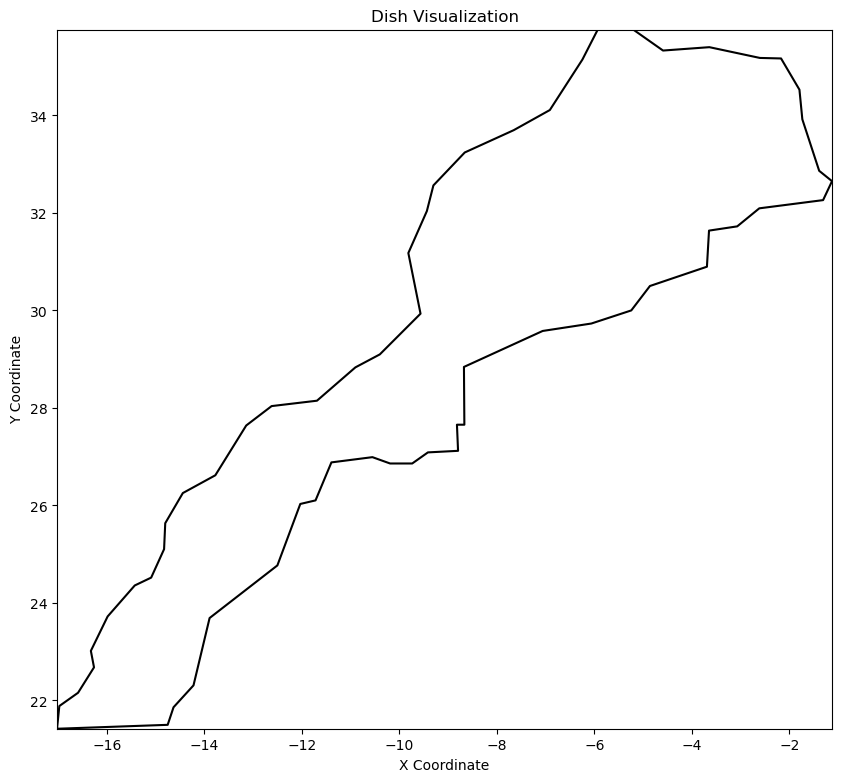

In [67]:
def visualize_dish(dish):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the polygon, if applicable
    if hasattr(dish, 'polygon') and dish.polygon is not None:
        x, y = dish.polygon.exterior.xy
        ax.plot(x, y, color='black')

    # Get bounds for the plot from the polygon
    bounds = dish.polygon.bounds
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    
    ax.set_aspect('equal')  # This will ensure that the aspect ratio is equal

    # Iterate through the lattice and plot food and slime cells
    for x in range(dish.lattice.shape[0]):
        for y in range(dish.lattice.shape[1]):
            cell = dish.lattice[x, y]
            if cell is not None:
                if isinstance(cell, FoodCell):
                    ax.plot(x, y, 'go')  # green dot for food cells
                elif isinstance(cell, SlimeCell):
                    ax.plot(x, y, 'ro')  # red dot for slime cells

    ax.set_title('Dish Visualization')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    plt.show()

# Use the function to visualize the dish
visualize_dish(dish)


ValueError: too many values to unpack (expected 2)

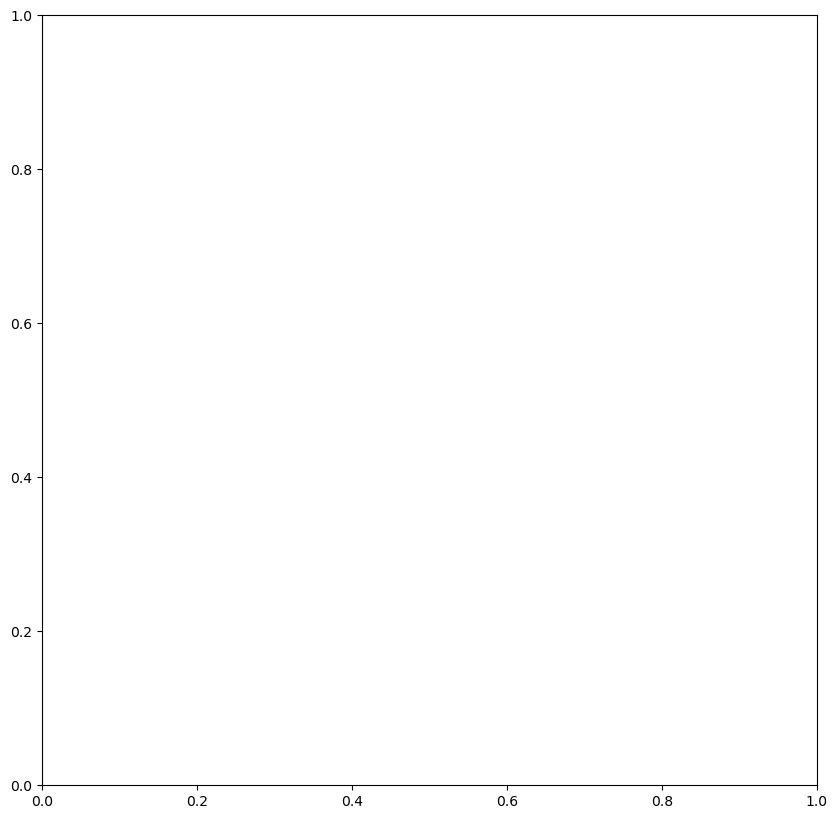

In [31]:
def visualize_transformed_cities(transformed_cities):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the cities using the transformed coordinates
    for city_id, (x, y) in transformed_cities.items():
        ax.plot(x, y, 'bo')  # blue dot for cities

    ax.set_title('Transformed Cities Visualization')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.grid(True)
    plt.show()

# Use the function to visualize the transformed cities
visualize_transformed_cities(transformed_cities)


### Test animation

TypeError: 'NoneType' object is not subscriptable

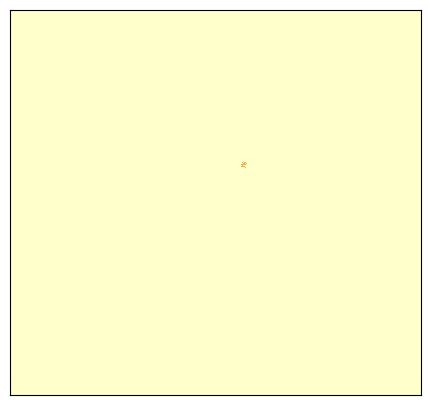

In [56]:
# Test the animation setup
def test_animation():
    frames = 50  # Number of frames in the animation
    interval = 100  # Time interval between frames in milliseconds
    filename = "output/50steps.gif"  # Filename to save the animation

    # Assuming the 'dish' object is already created and initialized
    # dish = Dish(...)  # Initialize the dish object here

    # Run the simulation
    animation = dish.animate(frames=frames, interval=interval, filename=filename)

    # To display the animation in the notebook
    plt.show()

    return animation

# Run the test
animation = test_animation()

TypeError: 'int' object is not subscriptable

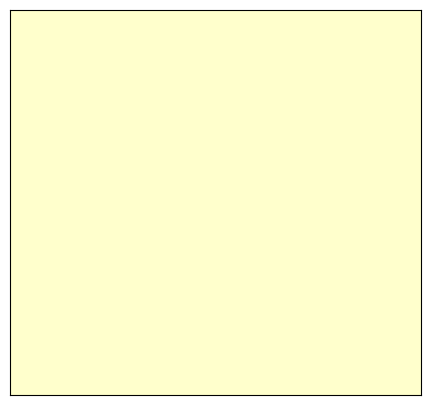

In [36]:
# Parameters
frames = 50  # Number of frames in the animation
interval = 100  # Interval between frames in milliseconds
filename = "output/50steps.gif"  # Filename to save the animation

# Run the simulation
animation = dish.animate(frames=frames, interval=interval, filename=filename)

# To display the animation in the notebook
plt.show()

In [21]:
dish.animate(frames=50, interval=100, filename="output/50steps.gif")
plt.show()

AttributeError: 'NoneType' object has no attribute 'pheromone'

<Figure size 630x500 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(6.3, 5))
nx.draw(dish.food_graph, dish.food_positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=12, 
        with_labels=False)
savefig('output/slime_graph_50steps.png')

### Animate 50 + 100 steps

In [ ]:
dish.animate(frames=100, interval=100, filename="output/150steps.gif")
plt.show()

In [ ]:
fig = plt.figure(figsize=(6.3, 5))
nx.draw(dish.food_graph, dish.food_positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=12, 
        with_labels=False)
savefig('output/slime_graph_150steps.png')

### Animate 50 + 100 + 100 steps

In [ ]:
dish.animate(frames=100, interval=100, filename="output/250steps.gif")
plt.show()

In [ ]:
nx.draw(dish.food_graph, dish.food_positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=12, 
        with_labels=False)
savefig('output/slime_graph_250steps.png')

### Animate 50 + 100 + 100 + 100 steps

In [ ]:
dish.animate(frames=100, interval=100, filename="output/350steps.gif")
plt.show()

In [ ]:
fig = plt.figure(figsize=(6.3, 5))
nx.draw(dish.food_graph, dish.food_positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=12, 
        with_labels=False)
savefig('output/slime_graph_350steps.png')

## Graph Analysis

### Statistics

In [ ]:
print('Clustering coefficient:')
print('Original graph: '+str(clustering_coefficient(G)))
print('Graph connected by slime mould: '+str(clustering_coefficient(dish.get_food_graph())))
print()

print('Path length:')
print('Original graph: '+str(characteristic_path_length(G)))
print('Graph connected by slime mould: '+str(characteristic_path_length(dish.get_food_graph())))
print()

print('Number of Nodes: '+str(len(G.nodes)))
print('Number of edges in the orginal graph: '+str(len(G.edges)))
print('Number of edges in the graph connected by slime mould: '+str(len(dish.get_food_graph().edges)))

### PMF in linear scale

In [ ]:
pmf_original = Pmf.from_seq(degrees(G))
pmf_slime = Pmf.from_seq(degrees(dish.get_food_graph()))
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
pmf_original.plot(label='Original Graph', color='C0')
decorate(xlabel='Degree', ylabel='PMF')

plt.subplot(1,2,2)
pmf_slime.plot(label='Slime Mould Graph', color='C2')
decorate(xlabel='Degree')
savefig('output/pmf.png')

## Agent Analysis

### Average pheromone of active agents

In [ ]:
plt.plot(dish.mould.get_avg_ph())
decorate(xlabel='Steps', ylabel='Average Pheromone', loc='upper left')
savefig('output/avg_ph.png')

### Number of agents

In [ ]:
plt.plot(dish.mould.get_total_num(), label='total agent')
plt.plot(dish.mould.get_total_active_num(), label='active agent')
plt.plot(dish.mould.get_total_inactive_num(), label='inactive agent')
decorate(xlabel='Steps', ylabel='Number of Agents', loc='upper left')
savefig('output/agent_num.png')

### Slime mould coverage ratio

In [ ]:
plt.plot(dish.mould.get_coverage_ratio())
decorate(xlabel='Steps', ylabel='Coverage Ratio', loc='upper left')
savefig('output/cover_ratio.png')

### Total number of connected food

In [ ]:
plt.plot(dish.mould.get_total_reached_foods())
decorate(xlabel='Steps', ylabel='Total Connected Food', loc='upper left')
savefig('output/connected_food.png')

## Parametric Study

### Experiments with different decay value

In [ ]:
moulds = {}
graphs = {}

start_loc = (cities.at[20,'x'], cities.at[20,'y'])

for i, decay in enumerate([0.15, 0.2, 0.25]):
    dish = Dish(dish_shape=(max(cities.x) + 50, max(cities.y) + 50), foods=cities, start_loc=start_loc, mould_shape=(5, 5), init_mould_coverage=1, decay=decay)
    while len(dish.mould.get_reached_food_ids()) != len(cities):
        dish.mould.evolve()
    moulds[i] = dish.mould
    graphs[i] = dish.get_food_graph()

### Clustering coefficient and path length

In [ ]:
cluster_coefs = []
paths = []
edge_num = []
node_num = []
for i, graph in graphs.items():
    cluster_coefs.append(clustering_coefficient(graph))
    paths.append(characteristic_path_length(graph))
    edge_num.append(len(graph.edges))
    node_num.append(len(graph.nodes))
dicts = {'decay':[0.15, 0.2, 0.25],'clustering coefficient': cluster_coefs, 'path length': paths, 'edges':edge_num, 'nodes': node_num}
pd.DataFrame(dicts)

### PMF in linear scale

In [ ]:
pmf_original = Pmf.from_seq(degrees(G))

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
pmf_original.plot(label='Original', color='C0')
decorate(xlabel='Degree', ylabel='PMF', loc='lower left')

plt.subplot(1,2,2)
for i, graph in graphs.items():
    pmf_slime = Pmf.from_seq(degrees(graph))
    pmf_slime.plot(label='Slime with '+str(0.15+0.05*i)+' decay' , color='C'+str(i))
decorate(xlabel='Degree', loc='lower left')
savefig('output/pmf_para.png')

### Number of steps for connecting all foods

In [ ]:
plt.figure(figsize=(6,3))
step_nums = {}
for i, mould in moulds.items():
    step_nums[str(0.15+0.05*i)] = len(mould.get_avg_ph())
plt.barh(*zip(*step_nums.items()))
decorate(xlabel='Decay', ylabel='Decay')
savefig('output/step_num_para.png')

### Average pheromone of active agents

In [ ]:
for i, mould in moulds.items():
    plt.plot(mould.get_avg_ph(), color='C'+str(i), label='decay='+str(0.15+0.05*i))
decorate(xlabel='Steps', ylabel='Average Pheromone', loc='lower right')
savefig('output/avg_ph_para.png')

### Number of agents

In [ ]:
plt.figure(figsize=(10,4))

for i, mould in moulds.items():
    if i == 0:
        plt.subplot(1,2,1)
        decorate(ylabel='Number of Agents')
        plt.plot(mould.get_total_num(), color='C'+str(i), label='total agents with '+str(0.15+0.05*i)+' decay')
        plt.plot(mould.get_total_active_num(), color='C'+str(i), label='active agents with '+str(0.15+0.05*i)+' decay', alpha=0.7)
        plt.plot(mould.get_total_inactive_num(), color='C'+str(i), label='inactive agents with '+str(0.15+0.05*i)+' decay', alpha=0.3)
        decorate(xlabel='Steps', loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(mould.get_total_num(), color='C'+str(i), label='total agents with '+str(0.15+0.05*i)+' decay')
    decorate(xlabel='Steps', loc='upper left')
savefig('output/agent_num_para.png')

### Slime mould coverage ratio

In [ ]:
for i, mould in moulds.items():
    plt.plot(mould.get_coverage_ratio(), color='C'+str(i), label=str(0.15+0.05*i)+'decay')
decorate(xlabel='Steps', ylabel='Coverage Ratio', loc='upper left')
savefig('output/cover_ratio_para.png')

### Total number of connected food

In [ ]:
for i, mould in moulds.items():
    plt.plot(mould.get_total_reached_foods(), color='C'+str(i), label='decay='+str(0.15+0.05*i))
decorate(xlabel='Steps', ylabel='Total Connected Food', loc='upper left')
savefig('output/connected_food_para.png')